Install all libraries and prerequisites

In [11]:
# tensorflow packages
!pip install absl-py
!pip install tensorflow
!pip install tensorflow-hub
# seaborn
!pip install seaborn
# ML
!pip install scikit-learn
# Facebook's pytorch
!pip install torch
# Hugging face
!pip install transformers datasets

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


Load the libraries

In [2]:
# Normal packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

# Deep learning
from absl import logging
import tensorflow as tf
import tensorflow_hub as hub

# Hugging Face
from transformers import pipeline

# Scikit-learn
from sklearn.cluster import KMeans

# NLP
from nltk import word_tokenize
from nltk.corpus import stopwords
import nltk

In [4]:
# Download some nltk required data
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to C:\Users\Michael
[nltk_data]     Cortes\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to C:\Users\Michael
[nltk_data]     Cortes\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

Load the data

In [3]:
df = pd.read_csv("drugLibTrain_raw.tsv", sep="\t")

df.shape

(3107, 9)

In [4]:
df.sample(10)

,Unnamed: 0,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
2764,1355,crestor,10,Highly Effective,No Side Effects,cholesterol,my cholesterol is well controlled now.blood te...,none. i found this drug very effectivewith no ...,1 pill taken on the morning each day.
1670,81,ventolin-hfa,10,Highly Effective,No Side Effects,asthma,I have had asthma for years and take albuterol...,none,two puffs as needed every four hours. I have ...
3095,1712,retin-a-micro,7,Considerably Effective,Mild Side Effects,acne,"At first, the acne on my face just went away. ...",I got my prescription for Retin-A Micro refill...,I apply it before bed each night and the acne'...
2268,861,valium,10,Highly Effective,No Side Effects,anxiety,After intolerable side effects of an anti depr...,Slight mental and phyical sedation (positive e...,It's long lasting nature often means that if I...
1288,2789,wellbutrin,10,Highly Effective,No Side Effects,depression,"freedom from depression, in addition, a greate...",none,I took 150mg daily
1254,3410,aricept,4,Moderately Effective,Severe Side Effects,memory,I believe I noticed some improvement in retain...,"Initially, I noticed no side effects. However,...",My doctor prescribed Aricept to aid my memory ...
2206,331,androgel,10,Highly Effective,Mild Side Effects,male andropause,Extremely better clarity of mind. Much higher...,At first I didn't realize that it was signific...,Rub gel on forearms twice per day. Extremely ...
2159,2450,symbyax,2,Ineffective,Moderate Side Effects,depression,the benefits were i was still depressed but no...,i had a racing heart beat but extreme tiredne...,i think this med sould be for very severe bipo...
1748,2610,adderall-xr,9,Considerably Effective,Mild Side Effects,adhd,"Patient was able to regain appropriate focus, ...","Patient reported feeling ""jittery"" initially. ...","Pt presented with hx of adhd, prescribed adder..."
2353,834,zegerid,10,Highly Effective,No Side Effects,gerd,It alleviated my Gastroesophageal Reflux Disea...,"I had no side effects what so ever, but there ...",The treatment consist of going to a Gastroente...


Limit data to reviews we wish to build topics off of

In [6]:
# Look at side effects only
sideEffectsReviews = df['sideEffectsReview'].dropna().tolist()

for i in [1, 10, 30, 101, 20, 500]:
    print(sideEffectsReviews[i])
    print('--------------------')

Heavy Cycle, Cramps, Hot Flashes, Fatigue, Long Lasting Cycles. It's only been 5 1/2 months, but i'm concidering changing to a different bc. This is my first time using any kind of bc, unfortunately due to the constant hassel, i'm not happy with the results.
--------------------
I did get a mild yeast infection during treatment.
--------------------
dry mouth, decreased appetite
--------------------
In the beginning I had very slight dizziness that would quickly subside and immediately noticed a significant decrease in appetite. After about 2 months it did not seem to work as well for the pain as it hd been. I also had what felt like strong muscle spasms that made my entire body twitch, but only for a second and only once in a while.  Therefore, I decided that I would discontinue taking the medication.  That is when my problems began.
--------------------
skin redness and flushes, sometimes the skin eels like it is on fire, and you feel very ho.
It is also very itchy when the skin is h

Load the deep Learning NLP Models (pretrained)

In [7]:
# Universal Sentence Encoder Model
USE_encoder = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") # multi-lingual

# Function to use USE encoder
def embed(input):
    return np.array(USE_encoder(input))


In [10]:
# Hugging Face sentiment scoring model

sentiment_model = pipeline("sentiment-analysis") # can accept a vector of sentences


No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [59]:
def sentiment(input):
    result = sentiment_model(input[:512]) # limit input string to be max of 512 characters
    sign = result[0]['label']
    score = result[0]['score']
    value = score if(sign == "POSITIVE") else -score
    return(value)


Create topic model

Past topic models
- LDA, LSA, Truncated SVD


In [60]:
class ReviewsTopicModel:

    STOPWORDS = stopwords.words('english') # nltk stopwords

    EMBEDDING_DIM = 512 # USE encoder

    # Constructor
    def __init__(self, reviews):
        self.X = self.clean(reviews)


    # Clean text method
    def clean(self, reviews):
        # Words to replace
        string_map = {'\r': '', '\n': '', '/': ' '}
        reviews_cleaned = reviews[:]
        for i in range(len(reviews_cleaned)):
            for s in string_map:
                reviews_cleaned[i] = reviews_cleaned[i].replace(s, string_map[s]).lower()
        # Transform these into embeddings
        X = embed(reviews_cleaned)
        X = pd.DataFrame(X)
        X.index = reviews_cleaned
        return X         

    def create_topics(self, num_topics):
        # Cluster the reviews
        kmeans = KMeans(n_clusters=num_topics)
        kmeans.fit(self.X)

        # Create the final topics dataframe
        self.topics_df = self.X.copy()
        self.topics_df['topic'] = kmeans.labels_.copy() # assign topic labels to original X data matrix
        self.topics_df['topic'] = self.topics_df['topic'].astype(int) # enforce topics to be integers

        # Create summary keywords
        self.topic_keywords = {}
        for topic in self.topics_df['topic'].unique():
            topic_reviews = self.topics_df.query("topic == {}".format(topic)).index.tolist()
            topic_centroid = kmeans.cluster_centers_[topic] # topic to be integer
            self.topic_keywords[topic] = self.get_closest_words(topic_reviews, topic_centroid)            
        self.topics_df['topic_keywords'] = self.topics_df['topic'].map(self.topic_keywords)

        # Score the sentiment of each review
        self.topics_df['sentiment'] = [sentiment(r) for r in self.topics_df.index.values.tolist()]

        # Final topics dataframe
        self.topics_df = self.topics_df[['topic', 'topic_keywords', 'sentiment']]


    def get_closest_words(self, reviews, centroid):
        word_distances = {}
        for r in reviews:
            review_words = [w for w in word_tokenize(r) if(w not in self.STOPWORDS)]
            for w in review_words:
                word_embedding = embed([w]) # returns 512 dimensional vector representation
                # how far is this word from the centroid of the topic? 
                word_distances[w] = self.cosine_similarity(word_embedding, centroid)
        # done collecting all word distances from topic's center
        top_5_keywords = sorted([(word_distances[w], w) for w in word_distances])[-5:]
        return ",".join([x[1] for x in top_5_keywords])

    def cosine_similarity(self, x, y):
        # x, y both should be 512 x 1 dimensional vectors
        x = x.reshape(self.EMBEDDING_DIM,)
        y = y.reshape(self.EMBEDDING_DIM,)
        # calculate cosine similarity
        dotproduct = x.dot(y)
        x_magnitude = x.dot(x)**0.5
        y_magnitude = y.dot(y)**0.5
        # returns cosine similarity, closer to 1 implies more similarity
        return dotproduct/(x_magnitude * y_magnitude)


    # Method to determine number of topics
    def elbow_plot(self, max_topics=10):
        cluster_sizes = list(range(1, max_topics))
        cluster_scores = []
        for n in cluster_sizes:
            kmeans = KMeans(n_clusters=n)
            kmeans.fit(self.X)
            cluster_scores.append(kmeans.inertia_)
        plt.figure()
        plt.plot(cluster_sizes, cluster_scores)
        plt.show()



Initialize model

In [61]:
# Instantiate the model
topic_model = ReviewsTopicModel(sideEffectsReviews)

Create elbow plot to determine optimal number of topics (i.e. clusters)

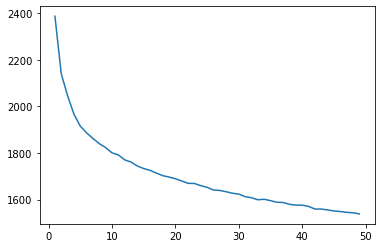

In [25]:
# Set the number of topics to extract from the text
topic_model.elbow_plot(max_topics=50)


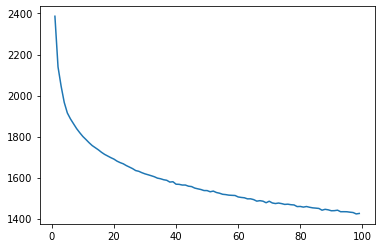

In [26]:
# Recreate the elbow plot at higher max topics 
topic_model.elbow_plot(max_topics=100)


Create final model and evaluate

In [62]:
topic_model.create_topics(num_topics=40)

In [73]:
select_topic = 15	
print(topic_model.topic_keywords[select_topic])
topic_model.topics_df.query("topic == {}".format(select_topic))

sleeplessness,drowsy,sleepiness,drowsiness,trazodone


,topic,topic_keywords,sentiment
it may cause some nervousness or restlessness. sometimes i felt like i had drank a large cup of coffee during its full potency.,15,"sleeplessness,drowsy,sleepiness,drowsiness,tra...",-0.995261
i have had some tirdeness and general sleep problems. i dont know if this was due to estrace or not. i have been someonewhat confused about hoe my energy has increased but my tirdness usually is in the morning when i take estrace. perhaps i should try evening.,15,"sleeplessness,drowsy,sleepiness,drowsiness,tra...",-0.997932
"the side effects made me yawn alot and very sleep, would take a 4 to 5 hour nap daily. my joints in my jaws were very stiff and made it almost painful for me to talk and especially where i yawned alot. i expierenced this side effect one day after taking the medication.",15,"sleeplessness,drowsy,sleepiness,drowsiness,tra...",-0.996903
"i sometimes feel groggy the morning after. the one time i took it nightly for 3 weeks, i had been under a great deal of stress, and then jet lag (i travelled to europe). in addition to the grogginess, i also just didn't feel good.very hard to describe, but a bit rundown and not clear-headed. for occasional use, it is better than the alternative, though i'm not sure i believe the time-release is worth the cost. next time i'll try the generic.",15,"sleeplessness,drowsy,sleepiness,drowsiness,tra...",-0.995565
can fall asleep at my desk or driving without much notice. reduced the amount i was taking from 200 mg to the 100mg.,15,"sleeplessness,drowsy,sleepiness,drowsiness,tra...",-0.999216
...,...,...,...
"sleepiness approximately 30 minutes after taking medicine, gas after the first day and for 3 days after course was finished, sun sensitivity",15,"sleeplessness,drowsy,sleepiness,drowsiness,tra...",-0.949092
"i felt slightly tired after taking zyrtec. however, this was not severe and i always took it in the evening because the information leaflet did mention that the drug can have these side effects. i was also always slightly more tired in the following morning (about 8-9 hrs after taking the drug) than typically.",15,"sleeplessness,drowsy,sleepiness,drowsiness,tra...",-0.992345
"side effects were mild upset stomach, insomnia if taken before bed, boosted my mood,and social life.",15,"sleeplessness,drowsy,sleepiness,drowsiness,tra...",-0.806341
only down side was it made waking up in the morning slightly harder if i took a dose too late in the evening and might make me fall asleep early if taken too soon.,15,"sleeplessness,drowsy,sleepiness,drowsiness,tra...",-0.998148


In [68]:
# Look at the average sentiment per topic

topic_model.topics_df.groupby(['topic', 'topic_keywords']).agg({'sentiment': 'mean'}).reset_index()\
        .sort_values(by='sentiment')



,topic,topic_keywords,sentiment
30,30,"ache,migraines,migraine,headache,headaches",-0.992774
4,4,"really,,,.,whatsoever,none",-0.987186
3,3,"nauseas,nauseous,nauseated,nausea,nausea-",-0.965302
29,29,"exception,least,never,anything,none",-0.956891
32,32,"tramadol,celebrex,lyrica,pains,fibromyalgia",-0.937553
37,37,"drowsy,drowsiness,tiredness,sleepiness,sleepin...",-0.918198
36,36,"diareah,diahrea,bowels,constipated,constipation",-0.914891
11,11,"nauseas,nexium,nausea,nauseated,gastritis",-0.908872
21,21,"nightmares,stool,diarrhea,constipated,constipa...",-0.904173
39,39,"vomiting,stomache,stomach,nauseous,nausea",-0.901900
